In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Homework 2
## Hypothesis testing

Each task is worth 5 points, 20 points in total. Additionally, some tasks allow you to get a bonus point, that **can not** increase your total score for the homework beyond the maximum, but can compensate for some occasionally lost points.

### Task 1: multiple comparisons

A randomized, double-blind experiment was conducted to assess the
effectiveness of several drugs for reducing postoperative nausea. The
data are as follows:

In [2]:
df1 = pd.DataFrame({'Drug': ['Placebo', 'Chlorpromazine', 'Dimenhydrinate', 'Pentobarbital (100 mg)', 'Pentobarbital (150 mg)'],
                    'Number of Patients': [80, 75, 85, 67, 85],
                    'Incidence of Nausea': [45, 26, 52, 35, 37]})
df1

,Drug,Number of Patients,Incidence of Nausea
0,Placebo,80,45
1,Chlorpromazine,75,26
2,Dimenhydrinate,85,52
3,Pentobarbital (100 mg),67,35
4,Pentobarbital (150 mg),85,37


1. Test each drug versus the placebo at the 5% level. Also, report
the estimated odds–ratios. Summarize your findings. (2 points)
2. Use the Bonferroni and the FDR method to adjust for multiple
testing. (Beecher (1959)) (3 points)
3. Reproduce plot similar to Figure 10.6 from the book, displaying observed $p$-values and different thresholds used (1 bonus point)

*Hint*. Use simple $H_0$: "$p_{drug} = p_{placebo}$".

1.

In [3]:
import scipy.stats as sst
alpha = 0.05
z = sst.norm.ppf(1 - alpha/2)

def wald_test_for_means(sample1, sample2, estimate=0, return_confint=False):
    mean = np.mean(sample1) - np.mean(sample2) - estimate
    se = np.sqrt(np.var(sample1) / len(sample1) + np.var(sample2) / len(sample2))
    statistic = np.abs(mean / se)
    pvalue = 2 * sst.norm.cdf(-np.abs(statistic))
    if not return_confint:
        return statistic, pvalue
    else:
        l = mean - z * se
        r = mean + z * se
        return statistic, pvalue, (l, r)

def drug_sample(name):
    n, a = df1[df1['Drug'] == name].values.T[1:]
    return np.concatenate([np.ones(a, dtype='int'), np.zeros(n - a, dtype='int')])

drug_names = df1['Drug'][1:]
p_vals = list()
odds = list()
rejects = list()
for drug_name in drug_names:
    odds_ratio = drug_sample(drug_name).mean() / drug_sample('Placebo').mean()
    stat, p_val = wald_test_for_means(drug_sample('Placebo'), drug_sample(drug_name))
    odds.append(odds_ratio)
    p_vals.append(p_val)
    rejects.append(p_val <= 0.05)

pd.DataFrame({'Drug': drug_names, 'p-value': p_vals, 'odds ratio': odds, 'reject': rejects})

,Drug,p-value,odds ratio,reject
1,Chlorpromazine,0.005703,0.616296,True
2,Dimenhydrinate,0.520232,1.087582,False
3,Pentobarbital (100 mg),0.626664,0.928690,False
4,Pentobarbital (150 mg),0.099639,0.773856,False


$H_0$ is confirmed at 5\% for all drugs except for chlorpromazine. It accords with the fact that odds ratio for chlorpromazine is the furthest from 1.

2.

In [4]:
from statsmodels.stats.multitest import multipletests

rejects_bon, pvals_bon, _, _ = multipletests(p_vals, method='bonferroni')
rejects_fdr, pvals_fdr, _, _ = multipletests(p_vals, method='fdr_bh')

res = pd.DataFrame({0: rejects_bon, 1: pvals_bon, 2: rejects_fdr, 3: pvals_fdr})
columns = [
    ('Bonferroni', 'reject'), ('Bonferroni', 'p-value'), ('FDR', 'reject'), ('FDR', 'p-value')
]
res.columns = pd.MultiIndex.from_tuples(columns)
res

Bonferroni              FDR          
      reject   p-value reject   p-value
0       True  0.022814   True  0.022814
1      False  1.000000  False  0.626664
2      False  1.000000  False  0.626664
3      False  0.398557  False  0.199278

Obtained rejects are the same as ordinary (computed without adjustment).

In [5]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# ax.plot()
# plt.show()

### Task 2: permutation test

In [6]:
df2 = pd.DataFrame({'person': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'], 
                    'left': [17.5, 18.4, 16.2, 14.5, 13.5, 18.9, 19.5, 21.1, 17.8, 16.8, 18.4, 17.3, 18.9, 16.4, 17.5, 15], 
                    'right': [17.6, 18.5, 15.9, 14.9, 13.7, 18.9, 19.5, 21.5, 18.5, 17.1, 18.9, 17.5, 19.5, 16.5, 17.4, 15.6]})
df2.head()

,person,left,right
0,A,17.5,17.6
1,B,18.4,18.5
2,C,16.2,15.9
3,D,14.5,14.9
4,E,13.5,13.7


We are interested in comparing the length of left hands and rights from 16 individuals. 

1. Compare histograms for left and right hands length (0.5 points)
2. Calculate independent samples permutation test (2 points)
3. Draw scatter plot for left and right hands length (0.5 points)
4. Calculate paires permutation test (2 points)
5. Which test performs better in this case? Why? (1 point)

1.

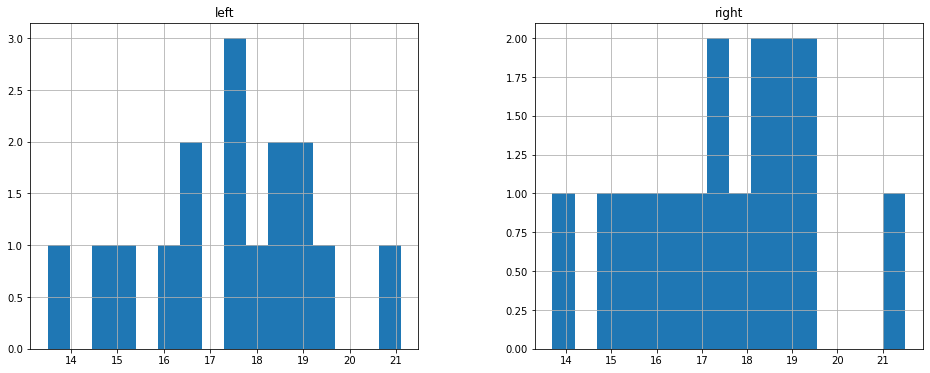

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
df2.hist(['left', 'right'], ax=ax, bins=16)
plt.show()

2. Here I use permutation test as it is given in lectures, considering $m = n = 16$

In [8]:
left = df2['left'].values
right = df2['right'].values
both = np.concatenate([left, right])

def perm_test(sample, m, n, n_perm=50000):
    assert n + m == len(sample)
    idx = range(len(sample))
    Ts = np.empty(n_perm)
    seen = set()
    i = 0
    while i < n_perm:
        new_idx = np.random.permutation(idx).tolist()
        if tuple(new_idx) not in seen:
            seen.add(tuple(new_idx))
            sample_ = sample[new_idx]
            x = sample_[:n]
            y = sample_[n:]
            Ts[i] = np.mean(x) - np.mean(y)
            i += 1
        else:
            continue
    return Ts

Ts = perm_test(both, 16, 16)

print(f'p-value {np.mean(Ts > left.mean() - right.mean()):.3f}')

p-value 0.638


3.

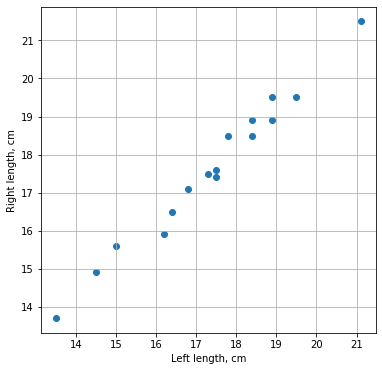

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(df2['left'], df2['right'])
ax.grid()
ax.set_xlabel('Left length, cm')
ax.set_ylabel('Right length, cm')
plt.show()

4. Here we consider $2^n$ possible swap variants of left and right length for each pair

In [10]:
Ts = list()
for i in range(2**16):
    i_bin = list(map(int, bin(i)[2:]))
    i_bin = [0] * (16 - len(i_bin)) + i_bin
    j = 0
    sample = np.empty((16, 2))
    for l, r in zip(left, right):
        if i_bin[j] == 1:
            sample[j] = r, l
        else:
            sample[j] = l, r
        j += 1
    Ts.append(sample[:,0].mean() - sample[:,1].mean())

Ts = np.array(Ts)
print(f'p-value {np.mean(Ts > left.mean() - right.mean()):.3f}')

p-value 0.998


5. Paired test performs better here, as samples are indeed dependent, because lengths were measured at the same people

### Task 3: computational approach to hypothesis testing

Recommended reading: http://allendowney.blogspot.com/2016/06/there-is-still-only-one-test.html

Consider the following dataset (service hours between failures of the air-conditioning equipment in a Boeing 727 jet aircraft , Proschan, 1963):

In [11]:
Y = np.array([3, 5, 7, 18, 43, 85, 91, 98, 100, 130, 230, 487])

This sample was sorted for easier presentation.

1. Compute an estimate of the median time between failures (1 point)
2. Consider the null hypothesis $H_0$ to be: "median time between failures is one week" (1 point)
3. What family of distributions will you choose for this kind of data under $H_0$? (1 point)
4. Choose a test statistic to measure the deviation from $H_0$ (1 point)
5. Check whether you can reject $H_0$ at significance level 5% and calculate the corresponding approximate $p$-value. Use 10,000 simulations for your experiment (1 point)
6. Plot histogram of the simulated values of the test statistic and mark the observed value and threshold that you obtained (1 bouns point)

1.

In [12]:
median = np.median(Y)
print(f'Median: {median}')

Median: 88.0


2. 7 days = 168 hours

$H_0 = \{m=168\}$

3. Considering results of queuing theory, we may model failure times sequence with homogeneous Poisson process with parameter $\lambda$. Then gaps between failures will belong to exponential distribution $Y \sim \text{Exp}(\lambda)$ with density function $f_{Y}(t) = \frac{1}{\lambda}e^{-\lambda t}$. As relation between parameter and median is $m = \frac{\ln 2}{\lambda}$, then $Y \sim \text{Exp}(\frac{\ln 2}{m})$

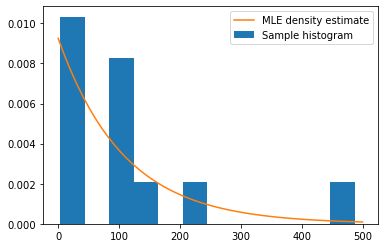

In [13]:
sample_distr_mle = sst.expon(scale=Y.mean())

x = np.linspace(0, 500)
plt.hist(Y, bins=12, density=True, label='Sample histogram')
plt.plot(x, sample_distr_mle.pdf(x), label='MLE density estimate')
plt.legend()
plt.show()

4. If $X_i \sim \text{Exp}(\lambda)$, then $Z = \sum_{i=1}^n X_i$ belongs to Erlang distribution $Z \sim \text{Erlang}(n, \lambda)$. Its theoretical expected value equals to $\frac{n}{\lambda}$

5. Hypothesis testing for given sample `Y`:

$p$-value computation includes two tails of distribution of $Z$: left from minus infinity to $l$ and right from $r$ to infinity.
$$
p = \int\limits_{-\infty}^{l} f_Z(x)dx + \int\limits_{r}^{+\infty} f_Z(x)dx = F_Z(l) + 1 - F_Z(r),
$$
where $l$ and $r$ are statistic and value symmetric to it against expected value

Statistic 1297; p-value 0.050


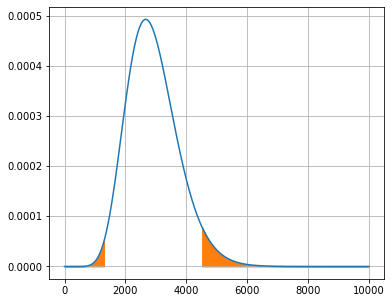

In [14]:
n = Y.size
lambda0 = np.log(2) / 168
zero_distr = sst.erlang(a=n, scale=1 / lambda0)
theor_exp = n / lambda0

def test_for_median(statistic=None, sample=None, input_sample=True):
    if input_sample:
        statistic = np.sum(sample)
    if statistic < theor_exp:
        l = statistic
        r = 2 * theor_exp - l
    else:
        r = statistic
        l = 2 * theor_exp - r
    pvalue = 1 - zero_distr.cdf(r) + zero_distr.cdf(l)
    return statistic, pvalue

stat, p_val = test_for_median(sample=Y)
print(f'Statistic {stat}; p-value {p_val:.3f}')

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
x = np.linspace(0, 10000, 1000)
ax.plot(x, zero_distr.pdf(x))
x1 = np.linspace(0, stat)
x2 = np.linspace(2*theor_exp - stat, 10000)
ax.fill_between(x1, 0, zero_distr.pdf(x1), color=colors[1])
ax.fill_between(x2, 0, zero_distr.pdf(x2), color=colors[1])
ax.grid()
plt.show()

For given data $p$-value equals exactly 5\%.

Let's sample test statistics from distribution obtained above:

In [15]:
stats = np.empty(10000)
rejects = np.empty(10000, dtype='bool')
pvals = np.empty(10000)
for i in range(10000):
    synth_stat = zero_distr.rvs()
    _, p = test_for_median(statistic=synth_stat, input_sample=False)
    stats[i] = synth_stat
    pvals[i] = p
    rejects[i] = p <= 0.05

In [16]:
print(f'Rejection rate on synthetic test statistics: {rejects.mean()}')

Rejection rate on synthetic test statistics: 0.0498


6.

Among obatined statistics, let's find minimal and maximal values of cases when the hyppothesis is accepted -- thresholds

In [17]:
res = np.stack([stats, pvals])
accepted = res[:,res[1] > 0.05][0]
bounds = [accepted.min(), accepted.max()]

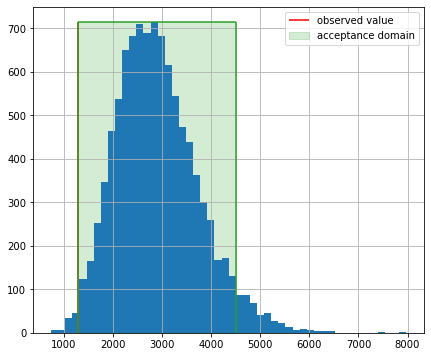

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
bins, _ ,_ = ax.hist(stats, bins=50)
ax.vlines(stat, 0, bins.max(), color='#ff0000', label='observed value')
ax.vlines(bounds, [0, 0], 2 * [bins.max()], color=colors[2])
ax.hlines(bins.max(), *bounds, color=colors[2])
ax.fill_between(bounds, 0, bins.max(), alpha=0.2, color=colors[2], label='acceptance domain')
ax.grid()
ax.legend()
plt.show()

Observed value is close to left threshold, but slightly less:

In [19]:
print(f'{stat} {bounds[0]:.3f}')

1297 1300.308


### Task 4

In 1861, 10 essays appeared in the New Orleans Daily Crescent. They
were signed “Quintus Curtius Snodgrass” and some people suspected
they were actually written by Mark Twain. To investigate this, we will
consider the proportion of three letter words found in an author’s work.
From eight Twain essays we have:

In [20]:
X = np.array([.225, .262, .217, .240, .230, .229, .235, .217])

From 10 Snodgrass essays we have:

In [21]:
Y = np.array([.209, .205, .196, .210, .202, .207, .224, .223, .220, .201])

1. Perform a Wald test for equality of the means. Use the nonparametric plug-in estimator. Report the $p$-value and a 95% confidence
interval for the difference of means. What do you conclude? (1.5 points)
2. Now use a permutation test to avoid the use of large sample methods.
What is your conclusion? (Brinegar (1963)) (1.5 points)
3. Assume that samples do indeed come from different populations. Additionally, observed sample means and variaces for the two samples are equal to the true values for the respective population. Estimate the power of the two tests above under two model distributions for the data: Normal and [Beta](https://en.wikipedia.org/wiki/Beta_distribution) (use the same family for both samples) (2 points)

1.

In [22]:
_, pval, (l, r) = wald_test_for_means(X, Y, return_confint=True)
print(f'p-value: {pval:.3e}')
print(f'Confidence interval for difference of means: [{l:.3f}, {r:.3f}]')

p-value: 7.993e-05
Confidence interval for difference of means: [0.011, 0.033]


Sample means significantly differ from each other

2.

In [23]:
both = np.concatenate([X, Y])
Ts = perm_test(both, X.size, Y.size)
p = np.mean(Ts > X.mean() - Y.mean())
print('Permutation test:')
print(f'p-value: {p:.3e}')

Permutation test:
p-value: 3.600e-04


In permutation test null hypothesis is rejected too

3.